# DeepWeedX - Simple CNN Model

## Libraries

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

## Import Dataset

In [30]:
TRAIN_CSV = "train_set_labels.csv"
TEST_CSV = "test_set_labels.csv"
IMAGE_DIR = "dataset"

train_df = pd.read_csv(TRAIN_CSV)
other_df = train_df[train_df['Species'] == 8].sample(n=1500, random_state=42)
non_other_df = train_df[train_df['Species'] != 8]
train_df = pd.concat([non_other_df, other_df]).sample(frac=1, random_state=42)

test_df = pd.read_csv(TEST_CSV)

### Training Dataset

In [31]:
train_df

,Label,Species
10632,20180125-094224-1.jpg,8
5894,20171113-124245-1.jpg,6
9745,20180119-110719-1.jpg,8
14502,20180112-081320-1.jpg,8
1076,20170714-132657-1.jpg,1
...,...,...
5734,20171113-121335-3.jpg,6
5191,20171122-101719-1.jpg,5
5390,20170913-104306-3.jpg,5
860,20170811-133311-2.jpg,0


In [32]:
print("Total training samples:", len(train_df))
print("Class distribution:\n", train_df['Species'].value_counts())

Total training samples: 8703
Class distribution:
 Species
8    1500
0     964
6     921
1     912
4     910
2     884
3     876
7     871
5     865
Name: count, dtype: int64


### Test Dataset

In [33]:
test_df

,Label,Species
0,20160928-141107-0.jpg,0
1,20160928-141135-0.jpg,0
2,20161207-110730-0.jpg,0
3,20161207-110850-0.jpg,0
4,20161207-112015-0.jpg,0
...,...,...
2496,20180322-120255-2.jpg,8
2497,20180322-120543-2.jpg,8
2498,20180322-120934-2.jpg,8
2499,20180322-121026-2.jpg,8


In [34]:
print("Total training samples:", len(test_df))
print("Class distribution:\n", test_df['Species'].value_counts())

Total training samples: 2501
Class distribution:
 Species
8    1301
0     161
6     153
1     152
4     152
2     147
3     146
7     145
5     144
Name: count, dtype: int64


## Hyperparameters

In [35]:
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
NUM_CLASSES = 9

## CNN MODEL

In [36]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2), padding='same'),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2), padding='same'),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\alper\OneDrive\Masaüstü\460\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 254016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │   130,056,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,241,865 (496.83 MB)

 Trainable params: 130,241,673 (496.83 MB)

 Non-trainable params: 192 (768.00 B)

## Training

In [37]:
train_images, train_labels = [], []
for _, row in train_df.iterrows():
    img_path = os.path.join(IMAGE_DIR, row['Label'])
    try:
        img = Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        train_images.append(np.array(img, dtype=np.float32) / 255.0)
        train_labels.append(row['Species'])
    except Exception as e:
        print(f"Error: {img_path} could not be loaded. Reason: {e}")

x_train = np.stack(train_images)
y_train = np.array(train_labels)

In [38]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))

In [39]:
print("Class Weights:")
for cls, weight in class_weights.items():
    print(f"Class {cls}: {weight:.2f}")

Class Weights:
Class 0: 1.00
Class 1: 1.06
Class 2: 1.09
Class 3: 1.10
Class 4: 1.06
Class 5: 1.12
Class 6: 1.05
Class 7: 1.11
Class 8: 0.64


In [40]:
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    class_weight=class_weights
)

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.1500 - loss: 34.3009 - val_accuracy: 0.1149 - val_loss: 5.5429
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.1058 - loss: 2.3957 - val_accuracy: 0.1040 - val_loss: 2.1996
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.0996 - loss: 2.2496 - val_accuracy: 0.1040 - val_loss: 2.1993
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.1100 - loss: 2.2386 - val_accuracy: 0.1040 - val_loss: 2.1995
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.1043 - loss: 2.2186 - val_accuracy: 0.1252 - val_loss: 2.1376
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.1117 - loss: 2.1906 - val_accuracy: 0.1137 - val_loss: 2.1693
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.1080 - loss: 2.1961 - val_accuracy: 0.0965 - val_loss: 2.1999
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.1396 - loss: 2.1811 - val_acc

### Results

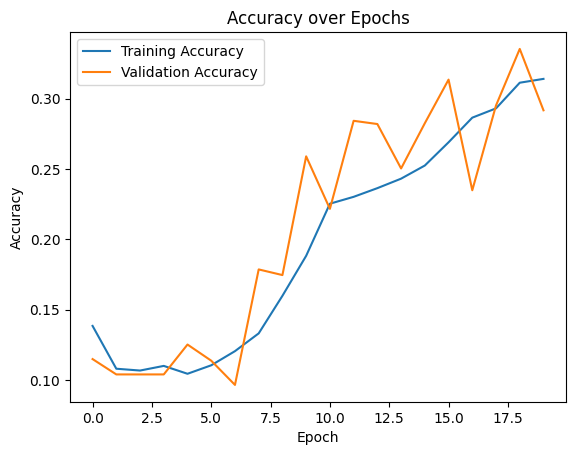

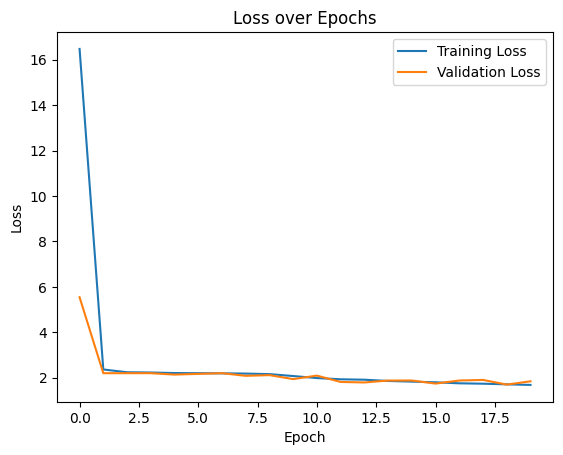

In [41]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#val_accuracy düşerken accuracy artıyorsa → overfitting var

## Test

In [42]:
test_images, test_labels = [], []
for _, row in test_df.iterrows():
    img_path = os.path.join(IMAGE_DIR, row['Label'])
    try:
        img = Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        test_images.append(np.array(img, dtype=np.float32) / 255.0)
        test_labels.append(row['Species'])
    except Exception as e:
        print(f"Error: {img_path} could not be loaded. Reason: {e}")

x_test = np.stack(test_images)
y_test = np.array(test_labels)

### Results

In [43]:
print("\nEvaluating model on test data:")
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Evaluating model on test data:
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step

Test Accuracy: 0.2694922031187525

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.85      0.27       161
           1       0.16      0.32      0.22       152
           2       0.28      0.46      0.34       147
           3       0.26      0.21      0.23       146
           4       0.00      0.00      0.00       152
           5       0.09      0.24      0.13       144
           6       0.32      0.50      0.39       153
           7       0.05      0.02      0.03       145
           8       0.90      0.21      0.34      1301

    accuracy                           0.27      2501
   macro avg       0.25      0.31      0.22      2501
weighted avg       0.55      0.27      0.28      2501



c:\Users\alper\OneDrive\Masaüstü\460\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alper\OneDrive\Masaüstü\460\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alper\OneDrive\Masaüstü\460\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

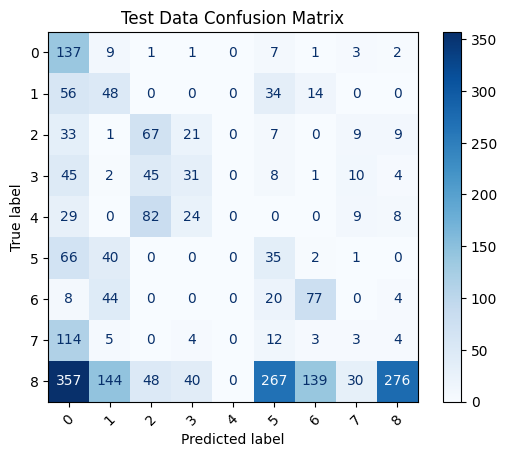

In [44]:
display_labels = [str(i) for i in range(NUM_CLASSES)]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot(cmap='Blues', xticks_rotation=45)
plt.title("Test Data Confusion Matrix")
plt.show()